### 使用昨天的卡通資料集來練GAN

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
from PIL import Image
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Conv2D, UpSampling2D, Dense, Flatten, Input, BatchNormalization, Reshape, LeakyReLU, Conv2DTranspose, Dropout

### 讀資料

In [3]:
class DataLoader:
    def __init__(self, folder_path, img_size):
        self.folder_path = folder_path
        self.img_size = img_size
        
        self.path_list = glob(folder_path) # 讀取資料夾全部圖片路徑
        assert len(self.path_list) > 0, 'path not existed!'
    
    def __imread(self, img_path):
        '''讀取圖片'''
        return np.array(Image.open(img_path).convert('RGB').resize(self.img_size[:-1]))
    
    def sampling_data(self, batch_size, shuffle=True):
        img_path_list = self.path_list
        
        if shuffle:
            random.shuffle(img_path_list)
            
        for batch_idx in range(0, len(img_path_list), batch_size):
            path_set = img_path_list[batch_idx : batch_idx + batch_size]
            
            # 預設空間，避免 append很慢
            img_set = np.zeros((len(path_set),) + self.img_size)
            for img_idx, path in enumerate(path_set):
                img_set[img_idx] = self.__imread(path)
            
            # 127.5是255的一半，一到負一之間
            img_set = img_set / 127.5 - 1
            # 暫停
            yield img_set

In [6]:
data = DataLoader('../0709/Preview/cartoon/*.png', (32, 32, 3))

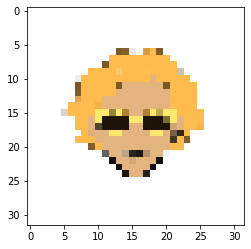

In [8]:
next_one = next(data.sampling_data(1))
# 強制變回 0到 1
plt.imshow(next_one[0]*.5+.5)

In [10]:
next_one[0].shape

(32, 32, 3)

### 建model

In [37]:
class GAN:
    def __init__(self, noise_dim, img_size=(64, 64, 3)):
        self.noise_dim = noise_dim # noise_dim = 雜訊維度
        self.img_size = img_size # img_size = 圖片大小
        self.dataloader = DataLoader('../0709/Preview/cartoon/*.png', self.img_size)
        
    def build_generator(self):
        noise_input = Input(shape=(self.noise_dim,))
        # TODO: Build generator
        # 首先，將輸入轉換為16x16 128通道的feature map
        x = Dense(128 * 16 * 16)(noise_input)
        x = LeakyReLU()(x)
        x = Reshape((16, 16, 128))(x)

        # 然後，添加捲積層
        x = Conv2D(256, 5, padding='same')(x)
        x = LeakyReLU()(x)

        # 上取樣至 64 x 64
        x = Conv2DTranspose(256, 4, strides=4, padding='same')(x)
        x = LeakyReLU()(x)

        # 新增更多的卷積層
        x = Conv2D(256, 5, padding='same')(x)
        x = LeakyReLU()(x)
        x = Conv2D(256, 5, padding='same')(x)
        x = LeakyReLU()(x)

        # 生成一個 64x64 3-channel 的feature map
        img = Conv2D(self.img_size[2], 7, activation='tanh', padding='same')(x)
        generator = Model(noise_input, img)
#         generator.summary()
        return generator

    def build_discriminator(self):
        img_input = Input(shape=self.img_size)
        # TODO: Build generator
        x = Conv2D(128, 3)(img_input)
        x = LeakyReLU()(x)
        x = Conv2D(128, 4, strides=2)(x)
        x = LeakyReLU()(x)
        x = Conv2D(128, 4, strides=2)(x)
        x = LeakyReLU()(x)
        x = Conv2D(128, 4, strides=2)(x)
        x = LeakyReLU()(x)
        x = Flatten()(x)

        # 重要的技巧（新增一個dropout層）
        x = Dropout(0,4)(x)

        # 分類層
        validity = Dense(1, activation='sigmoid')(x)

        discriminator = Model(img_input, validity)
#         discriminator.summary()
        return discriminator

    def connect(self):
        self.generator = self.build_generator()
        print(self.generator.count_params())
        self.discriminator = self.build_discriminator()
        print(self.discriminator.count_params())
        self.optimizer = Adam(.0002, .5)
        # Optimizer用Adam, Learning rate=0.0001~0.0002, 切勿調高
        self.discriminator.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['acc'])
        
        noise = Input(shape=(self.noise_dim,))
        img = self.generator(noise)
        self.discriminator.trainable = False # 在訓練G時, 鎖定D
        validity = self.discriminator(img)

        self.combined = Model(noise, validity)
        self.combined.compile(optimizer=self.optimizer, loss='binary_crossentropy')

    def train(self, epochs, batch_size, sample_interval=200):
        self.history = []
        valid = np.ones((batch_size, 1)) # 1 = 真實圖片
        fake = np.zeros((batch_size, 1)) # 0 = 生成圖片

        for e in range(epochs):
            for i, real_img in enumerate(self.dataloader.sampling_data(batch_size)):
                # Train D
                noise = np.random.standard_normal((batch_size, self.noise_dim))
                fake_img = self.generator.predict(noise)

                d_loss_real, real_acc = self.discriminator.train_on_batch(real_img, valid[:len(real_img)])
                d_loss_fake, fake_acc = self.discriminator.train_on_batch(fake_img, fake)
                d_loss = .5 * (d_loss_real + d_loss_fake)
                d_acc = .5 * (real_acc + fake_acc)
                                                                          
                # Train G
                noise = np.random.standard_normal((batch_size, self.noise_dim))
                g_loss = self.combined.train_on_batch(noise, valid)

                if i % sample_interval == 0:
                    info = {
                            'epoch': e,
                            'iter': i,
                            'd_loss': d_loss,
                            'd_acc': d_acc*100,
                            'g_loss': g_loss
                            }
                    self.history.append(list(info.values()))
                    print('[Epoch %(epoch)d][Iteration %(iter)d][D loss: %(d_loss).6f, acc: %(d_acc).2f%%][G loss: %(g_loss).6f]' % info)
            self.__sample_image(e)
        return self.history

    def __sample_image(self, epoch):
        r, c = 8, 8 # 列, 欄
        noise = np.random.standard_normal((r*c, self.noise_dim))
        img = self.generator.predict(noise).reshape((r, c) + self.img_size)
        img = img * .5 + .5
        fig = plt.figure(figsize=(20, 20))
        axs = fig.subplots(r, c)
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(img[i, j])
                axs[i, j].axis('off')
        fig.savefig('./Image/%5d.png' % epoch)
        plt.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 32768)             4227072   
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 64, 64, 256)       1048832   
__________

c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0][Iteration 0][D loss: 0.728728, acc: 0.00%][G loss: 0.691937]


c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0][Iteration 10][D loss: 0.014922, acc: 100.00%][G loss: 4.854350]
[Epoch 0][Iteration 20][D loss: 0.003170, acc: 100.00%][G loss: 6.216571]
[Epoch 0][Iteration 30][D loss: 0.001753, acc: 100.00%][G loss: 6.884169]
[Epoch 0][Iteration 40][D loss: 0.000591, acc: 100.00%][G loss: 7.690870]
[Epoch 0][Iteration 50][D loss: 0.000586, acc: 100.00%][G loss: 7.837948]
[Epoch 0][Iteration 60][D loss: 0.000636, acc: 100.00%][G loss: 8.223145]
[Epoch 0][Iteration 70][D loss: 0.000096, acc: 100.00%][G loss: 9.224287]
[Epoch 0][Iteration 80][D loss: 0.000143, acc: 100.00%][G loss: 8.871921]
[Epoch 0][Iteration 90][D loss: 0.000067, acc: 100.00%][G loss: 9.577305]
[Epoch 0][Iteration 100][D loss: 0.000055, acc: 100.00%][G loss: 9.724432]
[Epoch 0][Iteration 110][D loss: 0.000035, acc: 100.00%][G loss: 10.029843]
[Epoch 0][Iteration 120][D loss: 0.000069, acc: 100.00%][G loss: 9.908062]
[Epoch 0][Iteration 130][D loss: 0.000134, acc: 100.00%][G loss: 10.013607]
[Epoch 0][Iteration 140][D loss:

FileNotFoundError: [Errno 2] No such file or directory: './Image/00000.png'

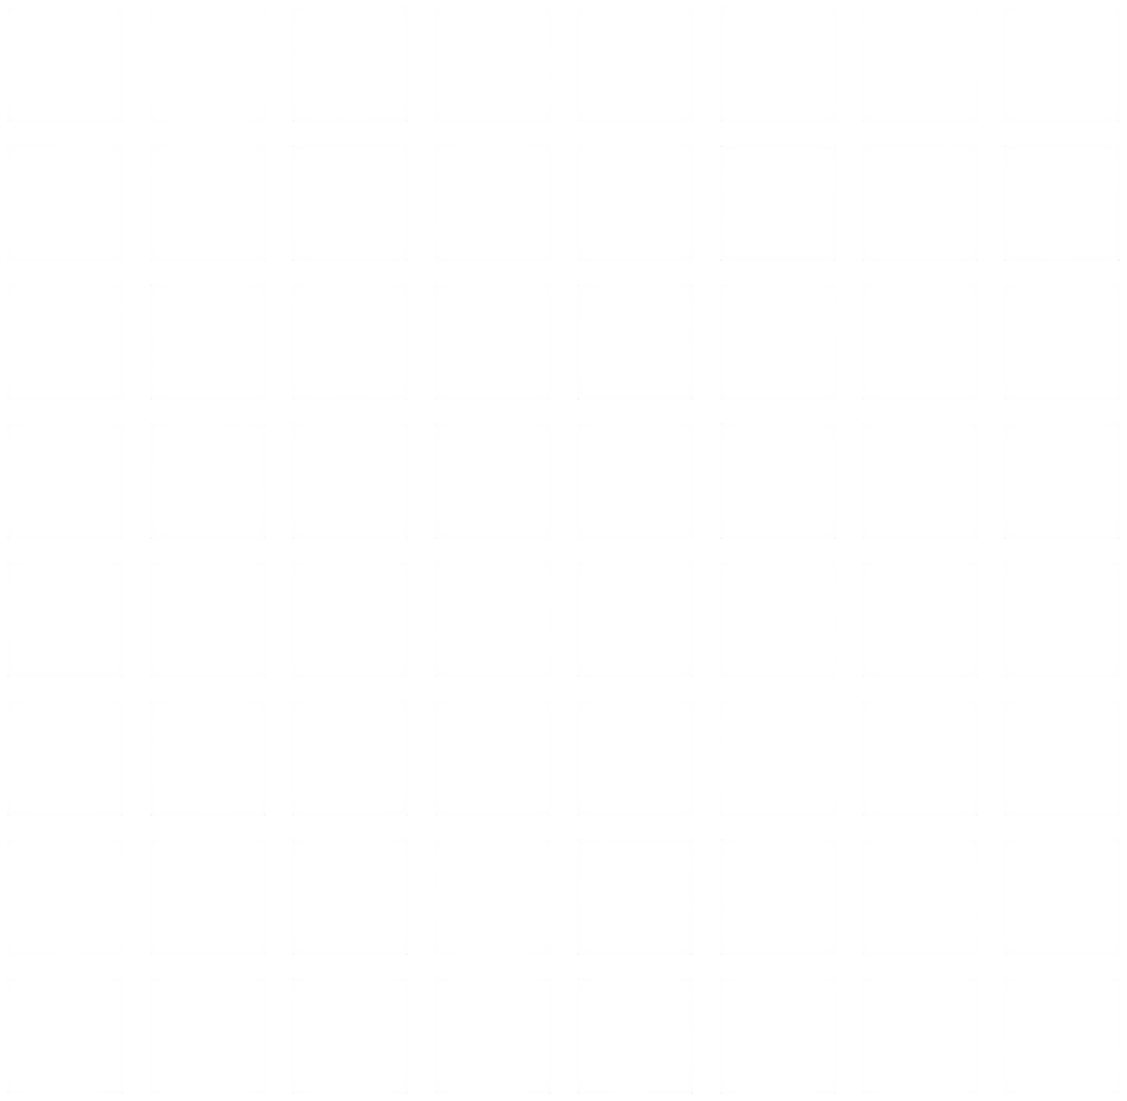

In [38]:
gan = GAN(128, img_size=(64, 64, 3))
gan.connect()
gan.train(10, 64, sample_interval=10)